In [241]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

## import packages needed in model fitting
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

## import packages needed in cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.metrics import classification_report

In [242]:
# get a list of file names in the working directory
lst = sorted(glob.glob('ForStudents/*.*'))
name='ForStudents\\SIRI_2018'
# filter the list of file names, only keep the file name starts with name, exclude July 3, Nov 23, and Dec 24
dates=list(filter(lambda x: x.startswith(name) and x[-9:-4]!='07-03' and x[-9:-4]!='11-23'and x[-9:-4]!='12-24' ,lst))
# sort the dates
dates.sort()
# convert list to numpy array
dates = np.array(dates)
days=dates.shape[0]

In [243]:
#Ignore the last second
seconds = 23399
size = 20
# there are 78 5-minute intervals in 6.5 hours
minutes = 78
BuyNumberMO = np.empty((days,seconds))
SellNumberMO = np.empty((days,seconds))
BuyVolumeMO = np.empty((days,seconds))
SellVolumeMO = np.empty((days,seconds))
#EventTime = np.empty((days,seconds))
BuyPrice = np.empty((days,seconds,size))
SellPrice = np.empty((days,seconds,size))
BuyVolume = np.empty((days,seconds,size))
SellVolume = np.empty((days,seconds,size))
MidPrice = np.empty((days,seconds))
Volatility = np.empty((days,minutes))
Volatility2 = np.empty((days,minutes))
MidVolume = np.empty((days,seconds))

for i in range(days):
    # load .mat files
    data = loadmat(dates[i])
    BuyNumberMO[i] = np.array(data['data']['NumberMO'][0][0])[:-1,0] #shape (23399)
    SellNumberMO[i] = np.array(data['data']['NumberMO'][0][0])[:-1,1] #shape (23399)
    BuyVolumeMO[i] = np.array(data['data']['VolumeMO'][0][0])[:-1,0] #shape (23399)
    SellVolumeMO[i] = np.array(data['data']['VolumeMO'][0][0])[:-1,1] #shape (23399)
    #EventTime[i] = np.array(data['data']['Eventime'][0][0])[:-1,0] #shape (23399)
    BuyPrice[i] = np.array(data['data']['BuyPrice'][0][0])[:-1]*1e-4 #shape (23399, 20)
    SellPrice[i] = np.array(data['data']['SellPrice'][0][0])[:-1]*1e-4 #shape (23399, 20)
    BuyVolume[i] = np.array(data['data']['BuyVolume'][0][0])[:-1] #shape (23399, 20)
    SellVolume[i] = np.array(data['data']['SellVolume'][0][0])[:-1] #shape (23399, 20)
    
    # calculate mid price
    MidPrice[i] = (BuyPrice[i,:,0] + SellPrice[i,:,0])/2 # shape (248, 23399)
    
# calculate volatility
for i in range(days):
    index = 0
    for j in range(minutes):
        if j == minutes:
            # calculate standard deviation of mid price from every 5-minute interval
            # since we exlucde the last second, in the 78th 5-minute interval, there are only 299 seconds
            Volatility[i,j] = np.std(MidPrice[i,index:index+299])
            # calculate the difference between the maximum and minimum of mid price from every 5-minute interval
            Volatility2[i,j] = np.max(MidPrice[i,index:index+299])-np.min(MidPrice[i,index:index+299])
        else:
            # calculate standard deviation of mid price from every 5-minute interval
            Volatility[i,j] = np.std(MidPrice[i,index:index+300])
            # calculate the difference between the maximum and minimum of mid price from every 5-minute interval
            Volatility2[i,j] = np.max(MidPrice[i,index:index+300])-np.min(MidPrice[i,index:index+300])
            index += 300

In [244]:
# standarized the dimension of each feature
stan_BuyNumberMO = np.empty((days,minutes))
stan_SellNumberMO = np.empty((days,minutes))
stan_BuyVolumeMO = np.empty((days,minutes))
stan_SellVolumeMO = np.empty((days,minutes))
stan_BuyPrice = np.empty((days,minutes))
stan_SellPrice = np.empty((days,minutes))
stan_BuyVolume = np.empty((days,minutes))
stan_SellVolume = np.empty((days,minutes))
stan_MidPrice = np.empty((days,minutes))
stan_PriceChange = np.empty((days,minutes))
temp_BuyPrice = np.mean(BuyPrice,axis=2) # shape = (days,seconds)
temp_SellPrice = np.mean(SellPrice,axis=2) # shape = (days,seconds)
temp_BuyVolume = np.mean(BuyVolume,axis=2) # shape = (days,seconds)
temp_SellVolume = np.mean(SellVolume,axis=2) # shape = (days,seconds)

for i in range(days):
    index = 0
    for j in range(minutes):
        if j == minutes:
            # calculate each feature from every 5-minute interval
            # since we exlucde the last second, in the 78th 5-minute interval, there are only 299 seconds
            stan_BuyNumberMO[i,j] = np.mean(BuyNumberMO[i,index:index+299])
            stan_SellNumberMO[i,j] = np.mean(SellNumberMO[i,index:index+299])
            stan_BuyVolumeMO[i,j] = np.mean(BuyVolumeMO[i,index:index+299])
            stan_SellVolumeMO[i,j] = np.mean(SellVolumeMO[i,index:index+299])
            stan_BuyPrice[i,j] = np.mean(temp_BuyPrice[i,index:index+299])
            stan_SellPrice[i,j] = np.mean(temp_SellPrice[i,index:index+299])
            stan_BuyVolume[i,j] = np.mean(temp_BuyVolume[i,index:index+299])
            stan_SellVlume[i,j] = np.mean(temp_SellVolume[i,index:index+299])
            stan_MidPrice[i,j] = np.mean(MidPrice[i,index:index+299])
        else:
            # calculate each feature from every 5-minute interval
            stan_BuyNumberMO[i,j] = np.mean(BuyNumberMO[i,index:index+300])
            stan_SellNumberMO[i,j] = np.mean(SellNumberMO[i,index:index+300])
            stan_BuyVolumeMO[i,j] = np.mean(BuyVolumeMO[i,index:index+300])
            stan_SellVolumeMO[i,j] = np.mean(SellVolumeMO[i,index:index+300])
            stan_BuyPrice[i,j] = np.mean(temp_BuyPrice[i,index:index+300])
            stan_SellPrice[i,j] = np.mean(temp_SellPrice[i,index:index+300])
            stan_BuyVolume[i,j] = np.mean(temp_BuyVolume[i,index:index+300])
            stan_SellVolume[i,j] = np.mean(temp_SellVolume[i,index:index+300])
            stan_MidPrice[i,j] = np.mean(MidPrice[i,index:index+300])
            index += 300

In [245]:
# standardize features
def Normalize(x, p):
    # linear transformation to make 
    #   P(a X +b < -1 ) = p
    #   P(a X +b > 1 ) = p

    q = np.quantile(x,[p, 1-p])
    a = 2.0 /(q[1]-q[0])
    b = 1.0 - a * q[1]
    
    return a*x+b 

def LogNormalize(x, p):
    
    y = np.log(1 + x / np.mean(x[x!=0],axis=0))
    
    return Normalize(y, p)

## Diurnal Patterns of Volatility

In [246]:
# plot diurnal pattern of volatility (Standard Deivation of Mid Price)
mRegimes=5
p = 1/mRegimes * np.arange(1,mRegimes)
# calculate 4 quantiles for every 5-minute interval
qtl = np.zeros((mRegimes-1,minutes)) # shape (4,78)
for i in range(minutes):
    qtl[:,i] = np.quantile(Volatility[:,i], p)
    
plt.figure(figsize=(15,6))
plt.plot(range(0,minutes),qtl[0],'blue', label = '1/5 Quantile', linewidth=1)
plt.plot(range(0,minutes),qtl[1],'orange', label ='2/5 Quantile', linewidth=1)
plt.plot(range(0,minutes),qtl[2],'green', label ='3/5 Quantile', linewidth=1)
plt.plot(range(0,minutes),qtl[3],'red', label ='4/5 Quantile', linewidth=1)
for i in range(days):
      plt.scatter(range(0,minutes),Volatility[i,:],s=0.5)
plt.xlabel('Time Period')    
plt.ylabel('Volatility (Standard Deivation of Mid Price)')
plt.title('Diurnal Pattern of Volatility (Standard Deivation of Mid Price)')
plt.legend()

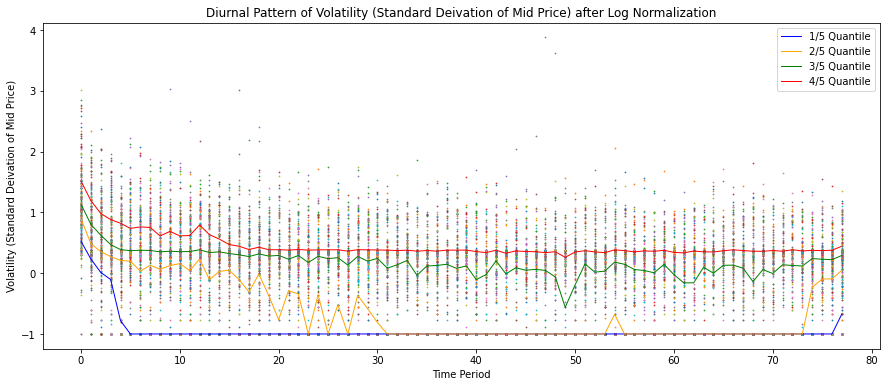

In [247]:
# plot diurnal pattern of volatility (Standard Deivation of Mid Price) after log normalization
mRegimes=5
p = 1/mRegimes * np.arange(1,mRegimes)
Volatility_logN=LogNormalize(Volatility,0.05)
# calculate 4 quantiles for every 5-minute interval
qtl_logN = np.zeros((mRegimes-1,minutes)) # shape (4,78)
for i in range(minutes):
    qtl_logN[:,i] = np.quantile(Volatility_logN[:,i], p)
    
# plot diurnal pattern of log normalized volatility
plt.figure(figsize=(15,6))
plt.plot(range(0,minutes),qtl_logN[0],'blue', label = '1/5 Quantile', linewidth=1)
plt.plot(range(0,minutes),qtl_logN[1],'orange', label ='2/5 Quantile', linewidth=1)
plt.plot(range(0,minutes),qtl_logN[2],'green', label ='3/5 Quantile', linewidth=1)
plt.plot(range(0,minutes),qtl_logN[3],'red', label ='4/5 Quantile', linewidth=1)
for i in range(days):
      plt.scatter(range(0,minutes),Volatility_logN[i,:],s=0.5)
plt.xlabel('Time Period')    
plt.ylabel('Volatility (Standard Deivation of Mid Price)')
plt.title('Diurnal Pattern of Volatility (Standard Deivation of Mid Price) after Log Normalization')
plt.legend()

In [248]:
# plot diurnal pattern of volatility (Range of Mid Price)
mRegimes=5
p = 1/mRegimes * np.arange(1,mRegimes)
# calculate 4 quantiles for every 5-minute interval
qtl2 = np.zeros((mRegimes-1,minutes)) # shape (4,78)
for i in range(minutes):
    qtl2[:,i] = np.quantile(Volatility2[:,i], p)
    
plt.figure(figsize=(15,6))
plt.plot(range(0,minutes),qtl2[0],'blue', label = '1/5 Quantile', linewidth=1)
plt.plot(range(0,minutes),qtl2[1],'orange', label ='2/5 Quantile', linewidth=1)
plt.plot(range(0,minutes),qtl2[2],'green', label ='3/5 Quantile', linewidth=1)
plt.plot(range(0,minutes),qtl2[3],'red', label ='4/5 Quantile', linewidth=1)
for i in range(days):
    plt.scatter(range(0,minutes),Volatility2[i,:],s=0.5)
plt.xlabel('Time Period')    
plt.ylabel('Volatility (Range of Mid Price)')
plt.title('Diurnal Pattern of Volatility (Range of Mid Price)')
plt.legend()

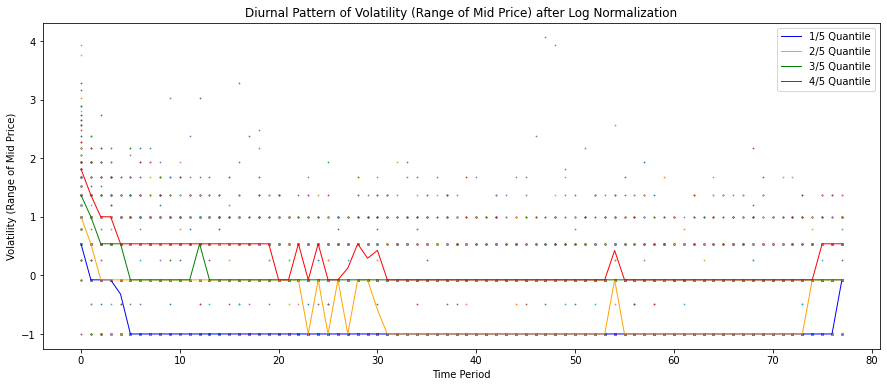

In [249]:
# plot diurnal pattern of volatility (Range of Mid Price) after log normalization
mRegimes=5
p = 1/mRegimes * np.arange(1,mRegimes)
Volatility2_logN=LogNormalize(Volatility2,0.05)
# calculate 4 quantiles for every 5-minute interval
qtl2_logN = np.zeros((mRegimes-1,minutes)) # shape (4,78)
for i in range(minutes):
    qtl2_logN[:,i] = np.quantile(Volatility2_logN[:,i], p)
    
plt.figure(figsize=(15,6))
plt.plot(range(0,minutes),qtl2_logN[0],'blue', label = '1/5 Quantile', linewidth=1)
plt.plot(range(0,minutes),qtl2_logN[1],'orange', label ='2/5 Quantile', linewidth=1)
plt.plot(range(0,minutes),qtl2_logN[2],'green', label ='3/5 Quantile', linewidth=1)
plt.plot(range(0,minutes),qtl2_logN[3],'red', label ='4/5 Quantile', linewidth=1)
for i in range(days):
      plt.scatter(range(0,minutes),Volatility2_logN[i,:],s=0.5)
plt.xlabel('Time Period')    
plt.ylabel('Volatility (Range of Mid Price)')
plt.title('Diurnal Pattern of Volatility (Range of Mid Price) after Log Normalization')
plt.legend()

## Polynomial Regression for Volatility Quantiles

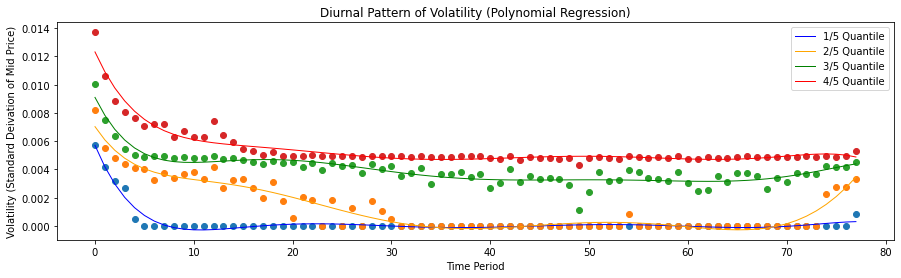

In [250]:
# fit polynomial regression
x = np.array(range(0,minutes))
X = x.reshape(-1, 1)

Y1 = qtl[0]
Y2 = qtl[1]
Y3 = qtl[2]
Y4 = qtl[3]
Y = [Y1,Y2,Y3,Y4]
fitted_qtl=np.zeros((4,minutes))

plt.figure(figsize=(15,4))
for i in range(4):
    
    lin_reg = LinearRegression()
    lin_reg.fit(X,Y[i])

    poly_reg = PolynomialFeatures(degree=7)
    X_poly = poly_reg.fit_transform(X)
    pol_reg = LinearRegression()
    pol_reg.fit(X_poly,Y[i])
    
    fitted_qtl[i] = pol_reg.predict(poly_reg.fit_transform(X))
    plt.scatter(X,Y[i])

plt.plot(X, fitted_qtl[0],'blue', label = '1/5 Quantile', linewidth=1)
plt.plot(X, fitted_qtl[1],'orange', label ='2/5 Quantile', linewidth=1)
plt.plot(X, fitted_qtl[2],'green', label ='3/5 Quantile', linewidth=1)
plt.plot(X, fitted_qtl[3],'red', label ='4/5 Quantile', linewidth=1)

plt.xlabel('Time Period')    
plt.ylabel('Volatility (Standard Deivation of Mid Price)')
plt.title('Diurnal Pattern of Volatility (Polynomial Regression)')
plt.legend()
plt.show()

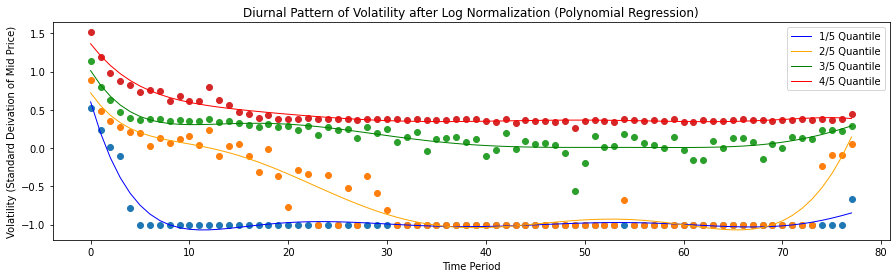

In [251]:
# fit polynomial regression with log normalized quantiles
x = np.array(range(0,minutes))
X = x.reshape(-1, 1)

Y1 = qtl_logN[0]
Y2 = qtl_logN[1]
Y3 = qtl_logN[2]
Y4 = qtl_logN[3]
Y = [Y1,Y2,Y3,Y4]
fitted_qtl_logN=np.zeros((4,minutes))

plt.figure(figsize=(15,4))
for i in range(4):
    
    lin_reg = LinearRegression()
    lin_reg.fit(X,Y[i])

    poly_reg = PolynomialFeatures(degree=7)
    X_poly = poly_reg.fit_transform(X)
    pol_reg = LinearRegression()
    pol_reg.fit(X_poly,Y[i])
    
    fitted_qtl_logN[i] = pol_reg.predict(poly_reg.fit_transform(X))
    plt.scatter(X,Y[i])

plt.plot(X, fitted_qtl_logN[0],'blue', label = '1/5 Quantile', linewidth=1)
plt.plot(X, fitted_qtl_logN[1],'orange', label ='2/5 Quantile', linewidth=1)
plt.plot(X, fitted_qtl_logN[2],'green', label ='3/5 Quantile', linewidth=1)
plt.plot(X, fitted_qtl_logN[3],'red', label ='4/5 Quantile', linewidth=1)

plt.xlabel('Time Period')    
plt.ylabel('Volatility (Standard Deivation of Mid Price)')
plt.title('Diurnal Pattern of Volatility after Log Normalization (Polynomial Regression)')
plt.legend()
plt.show()

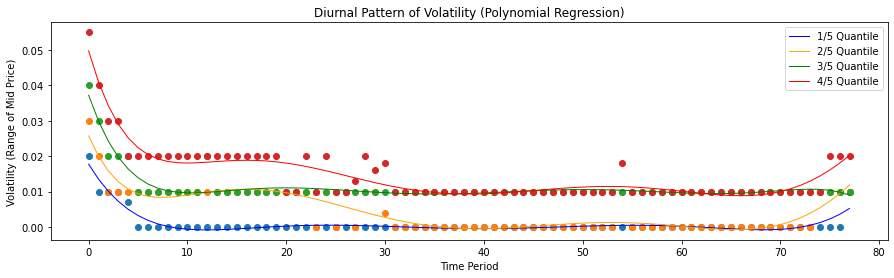

In [252]:
# fit polynomial regression
x = np.array(range(0,minutes))
X = x.reshape(-1, 1)

Y1 = qtl2[0]
Y2 = qtl2[1]
Y3 = qtl2[2]
Y4 = qtl2[3]
Y = [Y1,Y2,Y3,Y4]
fitted_qtl2=np.zeros((4,minutes))

plt.figure(figsize=(15,4))
for i in range(4):
    
    lin_reg = LinearRegression()
    lin_reg.fit(X,Y[i])

    poly_reg = PolynomialFeatures(degree=7)
    X_poly = poly_reg.fit_transform(X)
    pol_reg = LinearRegression()
    pol_reg.fit(X_poly,Y[i])
    
    fitted_qtl2[i] = pol_reg.predict(poly_reg.fit_transform(X))
    plt.scatter(X,Y[i])

plt.plot(X, fitted_qtl2[0],'blue', label = '1/5 Quantile', linewidth=1)
plt.plot(X, fitted_qtl2[1],'orange', label ='2/5 Quantile', linewidth=1)
plt.plot(X, fitted_qtl2[2],'green', label ='3/5 Quantile', linewidth=1)
plt.plot(X, fitted_qtl2[3],'red', label ='4/5 Quantile', linewidth=1)

plt.xlabel('Time Period')    
plt.ylabel('Volatility (Range of Mid Price)')
plt.title('Diurnal Pattern of Volatility (Polynomial Regression)')
plt.legend()
plt.show()

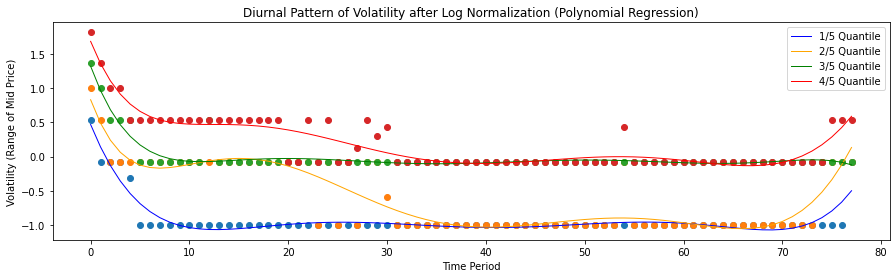

In [253]:
# fit polynomial regression with log normalized quantile
x = np.array(range(0,minutes))
X = x.reshape(-1, 1)

Y1 = qtl2_logN[0]
Y2 = qtl2_logN[1]
Y3 = qtl2_logN[2]
Y4 = qtl2_logN[3]
Y = [Y1,Y2,Y3,Y4]
fitted_qtl2_logN=np.zeros((4,minutes))

plt.figure(figsize=(15,4))
for i in range(4):
    
    lin_reg = LinearRegression()
    lin_reg.fit(X,Y[i])

    poly_reg = PolynomialFeatures(degree=7)
    X_poly = poly_reg.fit_transform(X)
    pol_reg = LinearRegression()
    pol_reg.fit(X_poly,Y[i])
    
    fitted_qtl2_logN[i] = pol_reg.predict(poly_reg.fit_transform(X))
    plt.scatter(X,Y[i])
    
plt.plot(X, fitted_qtl2_logN[0],'blue', label = '1/5 Quantile', linewidth=1)
plt.plot(X, fitted_qtl2_logN[1],'orange', label ='2/5 Quantile', linewidth=1)
plt.plot(X, fitted_qtl2_logN[2],'green', label ='3/5 Quantile', linewidth=1)
plt.plot(X, fitted_qtl2_logN[3],'red', label ='4/5 Quantile', linewidth=1)

plt.xlabel('Time Period')    
plt.ylabel('Volatility (Range of Mid Price)')
plt.title('Diurnal Pattern of Volatility after Log Normalization (Polynomial Regression)')
plt.legend()
plt.show()

In [254]:
# vol is volatility with dimension (days,minutes)
# fq is fitted_qtl has dimension (4,minutes)
# return an array of labels with dimension (days,minutes)
def genLabel(vol, fq):
    n=vol.shape[0]
    y=np.zeros((n,minutes))
    for i in range(0,n):
        for j in range(0,minutes):
            if vol[i,j] < fq[0,j]:
                y[i,j] = 0
            elif vol[i,j] >= fq[0,j] and vol[i,j] < fq[1,j]:
                y[i,j] = 1
            elif vol[i,j] >= fq[1,j] and vol[i,j] < fq[2,j]:    
                y[i,j] = 2
            elif vol[i,j] >= fq[2,j] and vol[i,j] < fq[3,j]:    
                y[i,j] = 3
            else:
                y[i,j]= 4         
    return y

In [255]:
true_label = genLabel(Volatility,fitted_qtl)
true_label2 = genLabel(Volatility2,fitted_qtl2)
true_label_logN = genLabel(Volatility_logN,fitted_qtl_logN)
true_label2_logN = genLabel(Volatility2_logN,fitted_qtl2_logN)

Text(0.5, 1.0, 'Histogram of Label for Volatility (Standard Deviation of Mid Price)')

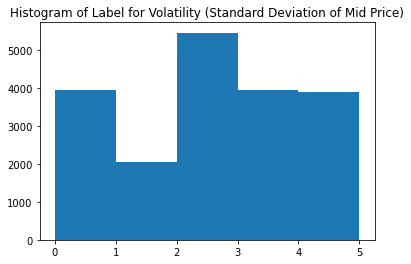

In [256]:
plt.hist(true_label.reshape(-1,),np.arange(0,6))
plt.title('Histogram of Label for Volatility (Standard Deviation of Mid Price)')

Text(0.5, 1.0, 'Histogram of Label for Volatility (Range of Mid Price)')

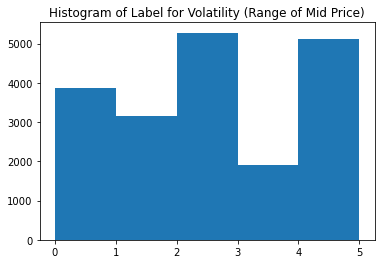

In [257]:
plt.hist(true_label2.reshape(-1,),np.arange(0,6))
plt.title('Histogram of Label for Volatility (Range of Mid Price)')

## Explore Univariate Distribution of Features

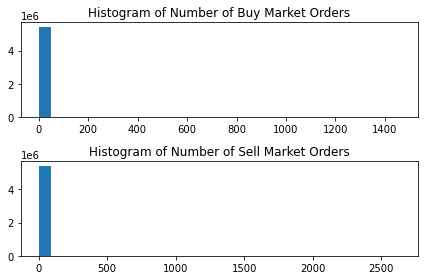

In [179]:
plt.subplot(2,1,1)
plt.hist(BuyNumberMO.reshape(-1,),bins=30)
plt.title('Histogram of Number of Buy Market Orders')
plt.tight_layout()

plt.subplot(2,1,2)
plt.hist(SellNumberMO.reshape(-1,),bins=30)
plt.title('Histogram of Number of Sell Market Orders')
plt.tight_layout()

In [ ]:
plt.subplot(2,1,1)
plt.hist(BuyVolumeMO.reshape(-1,),bins=30)
plt.title('Histogram of Buy Volume of Market Orders')
plt.tight_layout()

plt.subplot(2,1,2)
plt.hist(SellVolumeMO.reshape(-1,),bins=30)
plt.title('Histogram of Sell Volume of Market Orders')
plt.tight_layout()

In [ ]:
plt.subplot(2,1,1)
plt.hist(BuyPrice.reshape(-1,),bins=30)
plt.title('Histogram of Limit Order Buy Price')
plt.tight_layout()

plt.subplot(2,1,2)
plt.hist(SellPrice.reshape(-1,),bins=30)
plt.title('Histogram of Limit Order Sell Price')
plt.tight_layout()

In [ ]:
plt.subplot(2,1,1)
plt.hist(BuyVolume.reshape(-1,),bins=20)
plt.title('Histogram of Limit Order Buy Volume')
plt.tight_layout()

plt.subplot(2,1,2)
plt.hist(SellVolume.reshape(-1,),bins=20)
plt.title('Histogram of Limit Order Sell Volume')
plt.tight_layout()

In [ ]:
plt.hist(MidPrice.reshape(-1,),bins=40)
plt.title('Histogram of Mid Price')
plt.tight_layout()

In [ ]:
plt.hist(Volatility.reshape(-1,),bins=30)
plt.title('Histogram of Volatility (Standard Deviation of Mid Price)')
plt.tight_layout()

In [ ]:
plt.hist(Volatility2.reshape(-1,),bins=30)
plt.title('Histogram of Volatility (Range of Mid Price)')
plt.tight_layout()

## Histogram and KDE for Log Normalized Features

In [ ]:
def NormalizeFeatures(MidPrice, BuyNumberMO, SellNumberMO, BuyVolumeMO, SellVolumeMO, BuyPrice, \
                      SellPrice, BuyVolume, SellVolume, Volatility, Volatility2, p):
    x={}
    arr = np.empty((MidPrice.shape[0]))

    # feature 1: price change
    arr[1:] = MidPrice[1:] - MidPrice[:-1]
    arr[0] = 0
    x['PriceChange'] = Normalize(arr, p)
    
    # feature 2: BuyNumberMO
    x['BuyNumberMO'] = LogNormalize(BuyNumberMO, p)
    
    # feature 3: SellNumberMO
    x['SellNumberMO'] = LogNormalize(SellNumberMO, p)
    
    # feature 4: BuyVolumeMO
    x['BuyVolumeMO'] = LogNormalize(BuyVolumeMO, p)
    
    # feature 5: SellVolumeMO
    x['SellVolumeMO'] = LogNormalize(SellVolumeMO, p)
    
    # feature 6: BuyPrice
    x['BuyPrice'] = LogNormalize(BuyPrice, p)
    
    # feature 7: SellPrice
    x['SellPrice'] = LogNormalize(SellPrice, p)
    
    # feature 8 BuyVolume
    x['BuyVolume'] = LogNormalize(BuyVolume, p)
    
    # feature 9 SellVolume
    x['SellVolume'] = LogNormalize(SellVolume, p)
    
    # feature 10 Volatility (standard deviation of mid price)
    x['Volatility'] = LogNormalize(Volatility, p)
    
    # feature 11 Volatility2 (range of mid price)
    x['Volatility2'] = LogNormalize(Volatility2, p)
    
    # feature 12 Imbalance
    rho = (BuyVolume-SellVolume)/(BuyVolume+SellVolume)
    rho[(BuyVolume+SellVolume)==0] = 0
    x['Imbalance'] = Normalize(rho,p)
    
    # feature 13 MidPrice
    x['MidPrice']=LogNormalize(MidPrice,p)
    
    return x

features = NormalizeFeatures(MidPrice.reshape(-1,), BuyNumberMO.reshape(-1,), SellNumberMO.reshape(-1,), BuyVolumeMO.reshape(-1,), SellVolumeMO.reshape(-1,), BuyPrice.reshape(-1,), SellPrice.reshape(-1,), BuyVolume.reshape(-1,), SellVolume.reshape(-1,), Volatility.reshape(-1,), Volatility2.reshape(-1,), 0.05)

sns.distplot(features['PriceChange'],bins=(np.linspace(np.min(features['PriceChange']),np.max(features['PriceChange']),20)),\
             kde_kws={'clip': (np.min(features['PriceChange']), np.max(features['PriceChange']))}, hist=True)

plt.xlabel('PriceChange')
plt.title('Histogram for Price Change after Log Normalization with KDE')
plt.tight_layout()
plt.show()

plt.subplot(2,1,1)
sns.distplot(features['BuyNumberMO'],bins=(np.linspace(np.min(features['BuyNumberMO']), np.max(features['BuyNumberMO']),20)),\
             kde_kws={'clip': (np.min(features['BuyNumberMO']), np.max(features['BuyNumberMO']))}, hist=True)
plt.xlabel('BuyNumberMO')
plt.title('Histogram for Market Order Buy Counts with KDE after Log Normalization')

plt.subplot(2,1,2)
sns.distplot(features['SellNumberMO'],bins=(np.linspace(np.min(features['SellNumberMO']), np.max(features['SellNumberMO']),20)),\
             kde_kws={'clip': (np.min(features['SellNumberMO']), np.max(features['SellNumberMO']))}, hist=True)
plt.xlabel('SellNumberMO')
plt.title('Histogram for Market Order Sell Counts with KDE after Log Normalization')
plt.tight_layout()
plt.show()

plt.subplot(2,1,1)
sns.distplot(features['BuyVolumeMO'],bins=(np.linspace(np.min(features['BuyVolumeMO']), np.max(features['BuyVolumeMO']),20)),\
             kde_kws={'clip': (np.min(features['BuyVolumeMO']), np.max(features['BuyVolumeMO']))}, hist=True)

plt.xlabel('BuyVolumeMO')
plt.title('Histogram for Market Order Buy Volume with KDE after Log Normalization')

plt.subplot(2,1,2)
sns.distplot(features['SellVolumeMO'],bins=(np.linspace(np.min(features['SellVolumeMO']), np.max(features['SellVolumeMO']),20)),\
             kde_kws={'clip': (np.min(features['SellVolumeMO']), np.max(features['SellVolumeMO']))}, hist=True)

plt.xlabel('SellVolumeMO')
plt.title('Histogram for Market Order Sell Volume with KDE after Log Normalization')
plt.tight_layout()
plt.show()

plt.subplot(2,1,1)
sns.distplot(features['BuyPrice'],bins=(np.linspace(np.min(features['BuyPrice']),np.max(features['BuyPrice']),30)),  kde_kws={'clip': (np.min(features['BuyPrice']), np.max(features['BuyPrice']))}, hist=True)
plt.xlabel('BuyPrice')
plt.title('Histogram for Limit Order Buy Price after Log Normalization with KDE')

plt.subplot(2,1,2)
sns.distplot(features['SellPrice'],bins=(np.linspace(np.min(features['SellPrice']),np.max(features['SellPrice']),30)),  kde_kws={'clip': (np.min(features['SellPrice']), np.max(features['SellPrice']))}, hist=True)
plt.xlabel('SellPrice')
plt.title('Histogram for Limit Order Sell Price after Log Normalization with KDE')

plt.tight_layout()
plt.show()

plt.subplot(2,1,1)
sns.distplot(features['BuyVolume'],bins=(np.linspace(np.min(features['BuyVolume']),np.max(features['BuyVolume']),30)),  kde_kws={'clip': (np.min(features['BuyVolume']), np.max(features['BuyVolume']))}, hist=True)
plt.xlabel('BuyVolume')
plt.title('Histogram for Limit Order Buy Volume after Log Normalization with KDE')

plt.subplot(2,1,2)
sns.distplot(features['SellVolume'],bins=(np.linspace(np.min(features['SellVolume']),np.max(features['SellVolume']),30)),  kde_kws={'clip': (np.min(features['SellVolume']), np.max(features['SellVolume']))}, hist=True)
plt.xlabel('SellVolume')
plt.title('Histogram for Limit Order Sell Volume after Log Normalization with KDE')

plt.tight_layout()
plt.show()

plt.subplot(2,1,1)
sns.distplot(features['Volatility'],bins=(np.linspace(np.min(features['Volatility']),np.max(features['Volatility']),30)),  kde_kws={'clip': (np.min(features['Volatility']), np.max(features['Volatility']))}, hist=True)
plt.xlabel('Volatility')
plt.title('Histogram for Volatility (Standard Deviation of Mid Price) after Log Normalization with KDE')

plt.subplot(2,1,2)
sns.distplot(features['Volatility2'],bins=(np.linspace(np.min(features['Volatility2']),np.max(features['Volatility2']),30)),  kde_kws={'clip': (np.min(features['Volatility2']), np.max(features['Volatility2']))}, hist=True)
plt.xlabel('$Volatility_{2}$')
plt.title('Histogram for Volatility (Range of Mid Price) after Log Normalization with KDE')

plt.tight_layout()
plt.show()

sns.distplot(features['Imbalance'],bins=(np.linspace(np.min(features['Imbalance']),np.max(features['Imbalance']),30)),  kde_kws={'clip': (np.min(features['Imbalance']), np.max(features['Imbalance']))}, hist=True)
plt.xlabel('Imbalance')
plt.title('Histogram for Imbalance after Log Normalization with KDE')

plt.tight_layout()
plt.show()

sns.distplot(features['MidPrice'],bins=(np.linspace(np.min(features['MidPrice']),np.max(features['MidPrice']),30)),  kde_kws={'clip': (np.min(features['MidPrice']), np.max(features['MidPrice']))}, hist=True)
plt.xlabel('MidPrice')
plt.title('Histogram for Mid Price after Log Normalization with KDE')

plt.tight_layout()
plt.show()

In [258]:
X_arr = np.empty((days,minutes,13))
X_arr[:,:,0]=stan_BuyNumberMO
X_arr[:,:,1]=stan_SellNumberMO
X_arr[:,:,2]=stan_BuyVolumeMO
X_arr[:,:,3]=stan_SellVolumeMO
X_arr[:,:,4]=stan_BuyPrice
X_arr[:,:,5]=stan_SellPrice
X_arr[:,:,6]=stan_BuyVolume
X_arr[:,:,7]=stan_SellVolume
X_arr[:,:,8]=stan_MidPrice
X_arr[:,:,9]=Volatility
X_arr[:,:,10]=Volatility2
X_arr[:,:,11]=true_label
X_arr[:,:,12]=true_label2

In [259]:
# X_arr has shape of (days,minutes,13)
# returns (days*minutes,15)
def ScaleFeatures(X_arr, p):
    x=np.empty((days*minutes,15))
    arr = np.empty((X_arr.shape[0]*X_arr.shape[1]))
    
    # feature 1: BuyNumberMO
    x[:,0] = LogNormalize(np.ndarray.flatten(X_arr[:,:,0]), p)
    
    # feature 2: SellNumberMO
    x[:,1] = LogNormalize(np.ndarray.flatten(X_arr[:,:,1]), p)
    
    # feature 3: BuyVolumeMO
    x[:,2] = LogNormalize(np.ndarray.flatten(X_arr[:,:,2]), p)
    
    # feature 4: SellVolumeMO
    x[:,3] = LogNormalize(np.ndarray.flatten(X_arr[:,:,3]), p)
    
    # feature 5: BuyPrice
    x[:,4] = LogNormalize(np.ndarray.flatten(X_arr[:,:,4]), p)
    
    # feature 6: SellPrice
    x[:,5] = LogNormalize(np.ndarray.flatten(X_arr[:,:,5]), p)
    
    # feature 7 BuyVolume
    x[:,6] = LogNormalize(np.ndarray.flatten(X_arr[:,:,6]), p)
    
    # feature 8 SellVolume
    x[:,7] = LogNormalize(np.ndarray.flatten(X_arr[:,:,7]), p)
    
    # feature 9 volatility (standard deviation of mid price)
    x[:,8] = LogNormalize(np.ndarray.flatten(X_arr[:,:,9]), p)
    
    # feature 10 volatility2 (range of mid price)
    x[:,9] = LogNormalize(np.ndarray.flatten(X_arr[:,:,10]), p)
    
    # feature 11: price change
    arr[1:] = np.ndarray.flatten(X_arr[:,:,8])[1:] - np.ndarray.flatten(X_arr[:,:,8])[:-1]
    arr[0] = 0
    x[:,10] = Normalize(arr, p)
    
    # feature 12 imbalance
    rho = (X_arr[:,:,6]-X_arr[:,:,7])/(X_arr[:,:,6]+X_arr[:,:,7])
    rho = np.ndarray.flatten(rho)
    rho[(np.ndarray.flatten(X_arr[:,:,6]) + np.ndarray.flatten(X_arr[:,:,7]))==0] = 0
    x[:,11] = Normalize(rho,p)
    
    # feature 13 Mid Price
    x[:,12] = LogNormalize(X_arr[:,:,8].reshape(-1,) ,p)
    
    # feature 14 true label
    x[:,13] = LogNormalize(X_arr[:,:,11].reshape(-1,) ,p)
    
    # feature 15 true label2
    x[:,14] = LogNormalize(X_arr[:,:,12].reshape(-1,) ,p)
    
    return x

In [260]:
def plot_conf_mat(conf_mat, classes, model):

    fig = plt.figure(figsize=(12,15))
    
    ax = plt.subplot(1,2,1)
    
    ax.imshow(conf_mat, interpolation='nearest', cmap = plt.cm.Blues)
    
    ax.set(xticks=np.arange(conf_mat.shape[1]),
           yticks=np.arange(conf_mat.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title='Confusion Matrix for {}'.format(model),
           ylabel='True label',
           xlabel='Predicted label')

    fmt = 'd'
    thresh = conf_mat.max() / 2.
    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            ax.text(j, i, format(conf_mat[i, j], fmt),
                    ha="center", va="center",
                    color="white" if conf_mat[i, j] > thresh else "black") 
    
    
    conf_mat_nrm = conf_mat / np.sum(conf_mat, axis=1)[:, np.newaxis]
    
    ax = plt.subplot(1,2,2)
    
    ax.imshow(conf_mat_nrm, interpolation='nearest', cmap = plt.cm.Blues)
    
    ax.set(xticks=np.arange(conf_mat_nrm.shape[1]),
           yticks=np.arange(conf_mat_nrm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title='Confusion Matrix for {}'.format(model),
           ylabel='True label',
           xlabel='Predicted label')
    
    fmt = '.2f'
    thresh = conf_mat_nrm.max() / 2.
    for i in range(conf_mat_nrm.shape[0]):
        for j in range(conf_mat_nrm.shape[1]):
            ax.text(j, i, format(conf_mat_nrm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if conf_mat_nrm[i, j] > thresh else "black")
            
            
    fig.tight_layout()      
    
    plt.show()


##  5-Fold Cross Validation

In [ ]:
# X has shape (days,minutes,15)
# y has shape (days,minutes)
# return an array with shape (5,) 
def KFoldCV(X,y):
    lgm_pre = np.empty((days,minutes))
    rfc_pre = np.empty((days,minutes))
    dtree_pre = np.empty((days,minutes))
    knn_pre = np.empty((days,minutes))
    nn_pre = np.empty((days,minutes))
    
    lgm_pre[:,0]=y[:,0]
    rfc_pre[:,0]=y[:,0]
    dtree_pre[:,0]=y[:,0]
    knn_pre[:,0]=y[:,0]
    nn_pre[:,0]=y[:,0]
    
    for j in range(1,X.shape[1]):
        k=0
        kf = KFold(n_splits=5,shuffle=True)
        for train_index, test_index in kf.split(X):
            X_train = X[train_index,j-1,:]
            y_train = y[train_index,j]
            X_test = X[test_index,j-1,:]
            y_test = y[test_index,j]
            
            lgm = LogisticRegression(solver='newton-cg').fit(X_train,y_train)
            rfc = RandomForestClassifier(n_estimators=50).fit(X_train,y_train)
            dtree = DecisionTreeClassifier().fit(X_train,y_train)
            knn = KNeighborsClassifier().fit(X_train,y_train)
            nn = MLPClassifier(hidden_layer_sizes = (20,20),batch_size = 128, max_iter=5000).fit(X_train, y_train)

            lgm_pre[test_index,j] = lgm.predict(X_test)
            rfc_pre[test_index,j] = rfc.predict(X_test)
            dtree_pre[test_index,j] = dtree.predict(X_test)
            knn_pre[test_index,j] = knn.predict(X_test)
            nn_pre[test_index,j] = nn.predict(X_test)
                
            k+=1
            
    return lgm_pre, rfc_pre, dtree_pre, knn_pre, nn_pre

In [ ]:
label1_lgm_pre, label1_rfc_pre, label1_dtree_pre, label1_knn_pre, label1_nn_pre = KFoldCV(ScaleFeatures(X_arr,0.05).reshape(days,minutes,15),true_label)

In [ ]:
label2_lgm_pre, label2_rfc_pre, label2_dtree_pre, label2_knn_pre, label2_nn_pre = KFoldCV(ScaleFeatures(X_arr,0.05).reshape(days,minutes,15),true_label2)

In [ ]:
label1_acc=np.empty(5)
label1_acc[0] = accuracy_score(true_label[:,1:].reshape(-1,),label1_lgm_pre[:,1:].reshape(-1,))
label1_acc[1] = accuracy_score(true_label[:,1:].reshape(-1,),label1_rfc_pre[:,1:].reshape(-1,))
label1_acc[2] = accuracy_score(true_label[:,1:].reshape(-1,),label1_dtree_pre[:,1:].reshape(-1,))
label1_acc[3] = accuracy_score(true_label[:,1:].reshape(-1,),label1_knn_pre[:,1:].reshape(-1,))
label1_acc[4] = accuracy_score(true_label[:,1:].reshape(-1,),label1_nn_pre[:,1:].reshape(-1,))

In [ ]:
label2_acc=np.empty(5)
label2_acc[0] = accuracy_score(true_label2[:,1:].reshape(-1,),label2_lgm_pre[:,1:].reshape(-1,))
label2_acc[1] = accuracy_score(true_label2[:,1:].reshape(-1,),label2_rfc_pre[:,1:].reshape(-1,))
label2_acc[2] = accuracy_score(true_label2[:,1:].reshape(-1,),label2_dtree_pre[:,1:].reshape(-1,))
label2_acc[3] = accuracy_score(true_label2[:,1:].reshape(-1,),label2_knn_pre[:,1:].reshape(-1,))
label2_acc[4] = accuracy_score(true_label2[:,1:].reshape(-1,),label2_nn_pre[:,1:].reshape(-1,))

## Average Accuracy of 5-Fold Cross Validation for Each Model and Each Label

In [ ]:
## summary
summary_df = pd.DataFrame(columns=['Model','Cross Validation Accuracy - Label 1',
                                  'Cross Validation Accuracy - Label 2'])
summary_df['Model'] = ['Multiclass Logistic Regression','Random Forest','Decision Tree','K Nearest Neighbors','Neural Network']
summary_df['Cross Validation Accuracy - Label 1'] = label1_acc
summary_df['Cross Validation Accuracy - Label 2'] = label2_acc
summary_df

## Confusion Matrix and Classification Report

In [ ]:
print('Classification Report for Multiclass Logistic Regression:')
print(classification_report(true_label2[:,1:].reshape(-1,),label2_lgm_pre[:,1:].reshape(-1,),target_names=['Label 0','Label 1','Label 2','Label 3','Label 4']))
plot_conf_mat(confusion_matrix(true_label2[:,1:].reshape(-1,),label2_lgm_pre[:,1:].reshape(-1,)),['0','1','2','3','4'],'Multiclass Logistic Regression')

In [ ]:
print('Classification Report for Random Forest:')
print(classification_report(true_label2[:,1:].reshape(-1,),label2_rfc_pre[:,1:].reshape(-1,),target_names=['Label 0','Label 1','Label 2','Label 3','Label 4']))
plot_conf_mat(confusion_matrix(true_label2[:,1:].reshape(-1,),label2_rfc_pre[:,1:].reshape(-1,)),['0','1','2','3','4'],'Random Forest')

In [ ]:
print('Classification Report for Decision Tree:')
print(classification_report(true_label2[:,1:].reshape(-1,),label2_dtree_pre[:,1:].reshape(-1,),target_names=['Label 0','Label 1','Label 2','Label 3','Label 4']))
plot_conf_mat(confusion_matrix(true_label2[:,1:].reshape(-1,),label2_dtree_pre[:,1:].reshape(-1,)),['0','1','2','3','4'],'Decision Tree')

In [ ]:
print('Classification Report for K Nearest Neighbors:')
print(classification_report(true_label2[:,1:].reshape(-1,),label2_knn_pre[:,1:].reshape(-1,),target_names=['Label 0','Label 1','Label 2','Label 3','Label 4']))
plot_conf_mat(confusion_matrix(true_label2[:,1:].reshape(-1,),label2_knn_pre[:,1:].reshape(-1,)),['0','1','2','3','4'],'K Nearest Neighbors')

In [ ]:
print('Classification Report for Neural Network:')
print(classification_report(true_label2[:,1:].reshape(-1,),label2_nn_pre[:,1:].reshape(-1,),target_names=['Label 0','Label 1','Label 2','Label 3','Label 4']))
plot_conf_mat(confusion_matrix(true_label2[:,1:].reshape(-1,),label2_nn_pre[:,1:].reshape(-1,)),['0','1','2','3','4'],'Neural Network')

In [ ]:
plt.hist([true_label2[:,1:].reshape(-1,),label2_lgm_pre[:,1:].reshape(-1,)],label=['True Label', 'Predicted Label'])
plt.legend(loc='upper left')
plt.xlabel('Label')
plt.title('Histogram for True Label versus Predicted Label \n Using Multiclass Logistic Regression')
plt.show()

In [ ]:
unique_true,counts_true = np.unique(true_label2[:,1:].reshape(-1,),return_counts=True)

In [ ]:
counts_true

In [ ]:
unique_pre,counts_pre = np.unique(label2_lgm_pre[:,1:].reshape(-1,),return_counts=True)

In [ ]:
counts_pre

## Out of Sample Validation

In [261]:
def OutOfSampleCV(X_train, y_train):
  # get a list of file names in the working directory
    lst = sorted(glob.glob('Test Datasets/*.*'))
    name='Test Datasets\\AAL_2018'
    # filter the list of file names, only keep the file name starts with name, exclude July 3, Nov 23, and Dec 24
    dates=list(filter(lambda x: x.startswith(name) and x[-9:-4]!='07-03' and x[-9:-4]!='11-23'and x[-9:-4]!='12-24' ,lst))
    # sort the dates
    dates.sort()
    # convert list to numpy array
    dates = np.array(dates)
    days=dates.shape[0]
    
    #Ignore the last second
    seconds = 23399
    size = 20
    # there are 78 5-minute intervals in 6.5 hours
    minutes = 78
    BuyNumberMO = np.empty((days,seconds))
    SellNumberMO = np.empty((days,seconds))
    BuyVolumeMO = np.empty((days,seconds))
    SellVolumeMO = np.empty((days,seconds))
    #EventTime = np.empty((days,seconds))
    BuyPrice = np.empty((days,seconds,size))
    SellPrice = np.empty((days,seconds,size))
    BuyVolume = np.empty((days,seconds,size))
    SellVolume = np.empty((days,seconds,size))
    MidPrice = np.empty((days,seconds))
    Volatility = np.empty((days,minutes))
    Volatility2 = np.empty((days,minutes))
    MidVolume = np.empty((days,seconds))

    for i in range(days):
        # load .mat files
        data = loadmat(dates[i])
        BuyNumberMO[i] = np.array(data['data']['NumberMO'][0][0])[:-1,0] #shape (23399)
        SellNumberMO[i] = np.array(data['data']['NumberMO'][0][0])[:-1,1] #shape (23399)
        BuyVolumeMO[i] = np.array(data['data']['VolumeMO'][0][0])[:-1,0] #shape (23399)
        SellVolumeMO[i] = np.array(data['data']['VolumeMO'][0][0])[:-1,1] #shape (23399)
        #EventTime[i] = np.array(data['data']['Eventime'][0][0])[:-1,0] #shape (23399)
        BuyPrice[i] = np.array(data['data']['BuyPrice'][0][0])[:-1]*1e-4 #shape (23399, 20)
        SellPrice[i] = np.array(data['data']['SellPrice'][0][0])[:-1]*1e-4 #shape (23399, 20)
        BuyVolume[i] = np.array(data['data']['BuyVolume'][0][0])[:-1] #shape (23399, 20)
        SellVolume[i] = np.array(data['data']['SellVolume'][0][0])[:-1] #shape (23399, 20)
    
        # calculate mid price
        MidPrice[i] = (BuyPrice[i,:,0] + SellPrice[i,:,0])/2 # shape (248, 23399)
    
    # calculate volatility
    for i in range(days):
        index = 0
        for j in range(minutes):
            if j == minutes:
                # calculate standard deviation of mid price from every 5-minute interval
                # since we exlucde the last second, in the 78th 5-minute interval, there are only 299 seconds
                Volatility[i,j] = np.std(MidPrice[i,index:index+299])
                # calculate the difference between the maximum and minimum of mid price from every 5-minute interval
                Volatility2[i,j] = np.max(MidPrice[i,index:index+299])-np.min(MidPrice[i,index:index+299])
            else:
                # calculate standard deviation of mid price from every 5-minute interval
                Volatility[i,j] = np.std(MidPrice[i,index:index+300])
                # calculate the difference between the maximum and minimum of mid price from every 5-minute interval
                Volatility2[i,j] = np.max(MidPrice[i,index:index+300])-np.min(MidPrice[i,index:index+300])
                index += 300
                
    # standarized the dimension of each feature
    stan_BuyNumberMO = np.empty((days,minutes))
    stan_SellNumberMO = np.empty((days,minutes))
    stan_BuyVolumeMO = np.empty((days,minutes))
    stan_SellVolumeMO = np.empty((days,minutes))
    stan_BuyPrice = np.empty((days,minutes))
    stan_SellPrice = np.empty((days,minutes))
    stan_BuyVolume = np.empty((days,minutes))
    stan_SellVolume = np.empty((days,minutes))
    stan_MidPrice = np.empty((days,minutes))
    stan_PriceChange = np.empty((days,minutes))
    temp_BuyPrice = np.mean(BuyPrice,axis=2) # shape = (days,seconds)
    temp_SellPrice = np.mean(SellPrice,axis=2) # shape = (days,seconds)
    temp_BuyVolume = np.mean(BuyVolume,axis=2) # shape = (days,seconds)
    temp_SellVolume = np.mean(SellVolume,axis=2) # shape = (days,seconds)

    for i in range(days):
        index = 0
        for j in range(minutes):
            if j == minutes:
                # calculate each feature from every 5-minute interval
                # since we exlucde the last second, in the 78th 5-minute interval, there are only 299 seconds
                stan_BuyNumberMO[i,j] = np.mean(BuyNumberMO[i,index:index+299])
                stan_SellNumberMO[i,j] = np.mean(SellNumberMO[i,index:index+299])
                stan_BuyVolumeMO[i,j] = np.mean(BuyVolumeMO[i,index:index+299])
                stan_SellVolumeMO[i,j] = np.mean(SellVolumeMO[i,index:index+299])
                stan_BuyPrice[i,j] = np.mean(temp_BuyPrice[i,index:index+299])
                stan_SellPrice[i,j] = np.mean(temp_SellPrice[i,index:index+299])
                stan_BuyVolume[i,j] = np.mean(temp_BuyVolume[i,index:index+299])
                stan_SellVlume[i,j] = np.mean(temp_SellVolume[i,index:index+299])
                stan_MidPrice[i,j] = np.mean(MidPrice[i,index:index+299])
            else:
                # calculate each feature from every 5-minute interval
                stan_BuyNumberMO[i,j] = np.mean(BuyNumberMO[i,index:index+300])
                stan_SellNumberMO[i,j] = np.mean(SellNumberMO[i,index:index+300])
                stan_BuyVolumeMO[i,j] = np.mean(BuyVolumeMO[i,index:index+300])
                stan_SellVolumeMO[i,j] = np.mean(SellVolumeMO[i,index:index+300])
                stan_BuyPrice[i,j] = np.mean(temp_BuyPrice[i,index:index+300])
                stan_SellPrice[i,j] = np.mean(temp_SellPrice[i,index:index+300])
                stan_BuyVolume[i,j] = np.mean(temp_BuyVolume[i,index:index+300])
                stan_SellVolume[i,j] = np.mean(temp_SellVolume[i,index:index+300])
                stan_MidPrice[i,j] = np.mean(MidPrice[i,index:index+300])
                index += 300
                
    mRegimes=5
    p = 1/mRegimes * np.arange(1,mRegimes)
    # calculate 4 quantiles for every 5-minute interval
    qtl2 = np.zeros((mRegimes-1,minutes)) # shape (4,78)
    for i in range(minutes):
        qtl2[:,i] = np.quantile(Volatility2[:,i], p)

    # fit polynomial regression
    x = np.array(range(0,minutes))
    X = x.reshape(-1, 1)

    Y1 = qtl2[0]
    Y2 = qtl2[1]
    Y3 = qtl2[2]
    Y4 = qtl2[3]
    Y = [Y1,Y2,Y3,Y4]
    fitted_qtl2=np.zeros((4,minutes))

    plt.figure(figsize=(15,4))
    for i in range(4):
    
        lin_reg = LinearRegression()
        lin_reg.fit(X,Y[i])

        poly_reg = PolynomialFeatures(degree=7)
        X_poly = poly_reg.fit_transform(X)
        pol_reg = LinearRegression()
        pol_reg.fit(X_poly,Y[i])
    
        fitted_qtl2[i] = pol_reg.predict(poly_reg.fit_transform(X))
        #plt.scatter(X,Y[i])

    #plt.plot(X, fitted_qtl2[0],'blue', label = '1/5 Quantile', linewidth=1)
    #plt.plot(X, fitted_qtl2[1],'orange', label ='2/5 Quantile', linewidth=1)
    #plt.plot(X, fitted_qtl2[2],'green', label ='3/5 Quantile', linewidth=1)
    #plt.plot(X, fitted_qtl2[3],'red', label ='4/5 Quantile', linewidth=1)

    #plt.xlabel('Time Period')    
    #plt.ylabel('Volatility (Range of Mid Price)')
    #plt.title('Diurnal Pattern of Volatility (Polynomial Regression)')
    #plt.legend()
    #plt.show()
    
    true_label2 = genLabel(Volatility2,fitted_qtl2)

    X_arr = np.empty((days,minutes,11))
    X_arr[:,:,0]=stan_BuyNumberMO
    X_arr[:,:,1]=stan_SellNumberMO
    X_arr[:,:,2]=stan_BuyVolumeMO
    X_arr[:,:,3]=stan_SellVolumeMO
    X_arr[:,:,4]=stan_BuyPrice
    X_arr[:,:,5]=stan_SellPrice
    X_arr[:,:,6]=stan_BuyVolume
    X_arr[:,:,7]=stan_SellVolume
    X_arr[:,:,8]=stan_MidPrice
    X_arr[:,:,9]=Volatility
    X_arr[:,:,10]=Volatility2
    
    x_scale=np.empty((days*minutes,13))
    arr = np.empty((X_arr.shape[0]*X_arr.shape[1]))
    p=0.05
    
    # feature 1: BuyNumberMO
    x_scale[:,0] = LogNormalize(np.ndarray.flatten(X_arr[:,:,0]), p)
    
    # feature 2: SellNumberMO
    x_scale[:,1] = LogNormalize(np.ndarray.flatten(X_arr[:,:,1]), p)
    
    # feature 3: BuyVolumeMO
    x_scale[:,2] = LogNormalize(np.ndarray.flatten(X_arr[:,:,2]), p)
    
    # feature 4: SellVolumeMO
    x_scale[:,3] = LogNormalize(np.ndarray.flatten(X_arr[:,:,3]), p)
    
    # feature 5: BuyPrice
    x_scale[:,4] = LogNormalize(np.ndarray.flatten(X_arr[:,:,4]), p)
    
    # feature 6: SellPrice
    x_scale[:,5] = LogNormalize(np.ndarray.flatten(X_arr[:,:,5]), p)
    
    # feature 7 BuyVolume
    x_scale[:,6] = LogNormalize(np.ndarray.flatten(X_arr[:,:,6]), p)
    
    # feature 8 SellVolume
    x_scale[:,7] = LogNormalize(np.ndarray.flatten(X_arr[:,:,7]), p)
    
    # feature 9 volatility (standard deviation of mid price)
    x_scale[:,8] = LogNormalize(np.ndarray.flatten(X_arr[:,:,9]), p)
    
    # feature 10 volatility2 (range of mid price)
    x_scale[:,9] = LogNormalize(np.ndarray.flatten(X_arr[:,:,10]), p)
    
    # feature 11: price change
    arr[1:] = np.ndarray.flatten(X_arr[:,:,8])[1:] - np.ndarray.flatten(X_arr[:,:,8])[:-1]
    arr[0] = 0
    x_scale[:,10] = Normalize(arr, p)
    
    # feature 12 imbalance
    rho = (X_arr[:,:,6]-X_arr[:,:,7])/(X_arr[:,:,6]+X_arr[:,:,7])
    rho = np.ndarray.flatten(rho)
    rho[(np.ndarray.flatten(X_arr[:,:,6]) + np.ndarray.flatten(X_arr[:,:,7]))==0] = 0
    x_scale[:,11] = Normalize(rho,p)
    
    # feature 13 Mid Price
    x_scale[:,12] = LogNormalize(X_arr[:,:,8].reshape(-1,) ,p)
    
    X_test = x_scale.reshape(days,minutes,13)
    y_test = true_label2
    
    lgm_pre = np.empty((days,minutes))
    
    lgm_pre[:,0]=y_test[:,0]
    
    for j in range(1,minutes):
        lgm = LogisticRegression(solver='newton-cg').fit(X_train[:,j-1,:],y_train[:,j])
        lgm_pre[:,j] = lgm.predict(X_test[:,j-1,:])
    
    print('Classification Report for Multiclass Logistic Regression:')
    print(classification_report(y_test[:,1:].reshape(-1,),lgm_pre[:,1:].reshape(-1,),target_names=['Label 0','Label 1','Label 2','Label 3','Label 4']))
    plot_conf_mat(confusion_matrix(y_test[:,1:].reshape(-1,),lgm_pre[:,1:].reshape(-1,)),['0','1','2','3','4'],'Multiclass Logistic Regression')

Classification Report for Multiclass Logistic Regression:
              precision    recall  f1-score   support

     Label 0       0.37      0.23      0.28       100
     Label 1       0.16      0.14      0.15        73
     Label 2       0.15      0.31      0.20        58
     Label 3       0.24      0.17      0.20        65
     Label 4       0.29      0.29      0.29        89

    accuracy                           0.23       385
   macro avg       0.24      0.23      0.22       385
weighted avg       0.26      0.23      0.23       385



<Figure size 1080x288 with 0 Axes>

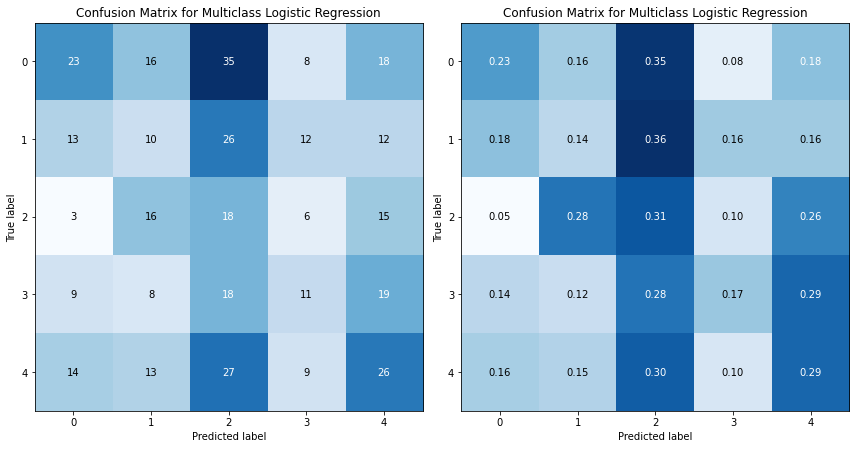

In [262]:
OutOfSampleCV(ScaleFeatures(X_arr,0.05)[:,:-2].reshape(days,minutes,13),true_label2)